# Random Coefficients Logit Tutorial with the Automobile Data

In [4]:
import pyblp
import numpy as np
import pandas as pd 

pyblp.options.digits = 2
pyblp.options.verbose = False
pyblp.__version__

'0.12.0'

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

ModuleNotFoundError: No module named 'matplotlib'

Please use data from [Berry, Levinsohn, and Pakes (1995)](https://pyblp.readthedocs.io/en/stable/references.html#berry-levinsohn-and-pakes-1995) to estimate a model and simulate a merger in the automobile industry.


## Merger Analysis with Automobile Data


### Loading the Data

Use [pandas](https://pandas.pydata.org/) to load two sets of data:

1. `product_data`, which contains prices, shares, and other product characteristics.
2. `agent_data`, which contains draws from the distribution of heterogeneity.

In [6]:
product_data = pd.read_csv(pyblp.data.BLP_PRODUCTS_LOCATION)
product_data.head()

,market_ids,clustering_ids,car_ids,firm_ids,region,shares,prices,hpwt,air,mpd,...,supply_instruments2,supply_instruments3,supply_instruments4,supply_instruments5,supply_instruments6,supply_instruments7,supply_instruments8,supply_instruments9,supply_instruments10,supply_instruments11
0,1971,AMGREM71,129,15,US,0.001051,4.935802,0.528997,0,1.888146,...,0.0,1.705933,1.595656,87.0,-61.959985,0.0,46.060389,29.786989,0.0,1.888146
1,1971,AMHORN71,130,15,US,0.000670,5.516049,0.494324,0,1.935989,...,0.0,1.680910,1.490295,87.0,-61.959985,0.0,46.060389,29.786989,0.0,1.935989
2,1971,AMJAVL71,132,15,US,0.000341,7.108642,0.467613,0,1.716799,...,0.0,1.801067,1.357703,87.0,-61.959985,0.0,46.060389,29.786989,0.0,1.716799
3,1971,AMMATA71,134,15,US,0.000522,6.839506,0.426540,0,1.687871,...,0.0,1.818061,1.261347,87.0,-61.959985,0.0,46.060389,29.786989,0.0,1.687871
4,1971,AMAMBS71,136,15,US,0.000442,8.928395,0.452489,0,1.504286,...,0.0,1.933210,1.237365,87.0,-61.959985,0.0,46.060389,29.786989,0.0,1.504286


In [9]:
len(product_data.columns)

33

In [4]:
agent_data = pd.read_csv(pyblp.data.BLP_AGENTS_LOCATION)
agent_data.head()

,market_ids,weights,nodes0,nodes1,nodes2,nodes3,nodes4,income
0,1971,0.000543,1.192188,0.478777,0.980830,-0.824410,2.473301,109.560369
1,1971,0.000723,1.497074,-2.026204,-1.741316,1.412568,-0.747468,45.457314
2,1971,0.000544,1.438081,0.813280,-1.749974,-1.203509,0.049558,127.146548
3,1971,0.000701,1.768655,-0.177453,0.286602,0.391517,0.683669,22.604045
4,1971,0.000549,0.849970,-0.135337,0.735920,1.036247,-1.143436,170.226032


Check https://pyblp.readthedocs.io/en/stable/_notebooks/tutorial/blp.html to see how to estimate the BLP model.

In [5]:
product_formulations = (
   pyblp.Formulation('1 + hpwt + air + mpd + space'),
   pyblp.Formulation('1 + prices + hpwt + air + mpd + space'),
   pyblp.Formulation('1 + log(hpwt) + air + log(mpg) + log(space) + trend')
)
product_formulations

(1 + hpwt + air + mpd + space,
 1 + prices + hpwt + air + mpd + space,
 1 + log(hpwt) + air + log(mpg) + log(space) + trend)

In [6]:
agent_formulation = pyblp.Formulation('0 + I(1 / income)')
agent_formulation

I(1 / income)

In [7]:
problem = pyblp.Problem(product_formulations, product_data, agent_formulation, agent_data, costs_type='log')
problem

Dimensions:
 T    N     F    I     K1    K2    K3    D    MD    MS 
---  ----  ---  ----  ----  ----  ----  ---  ----  ----
20   2217  26   4000   5     6     6     1    13    18 

Formulations:
       Column Indices:            0          1       2       3          4         5  
-----------------------------  --------  ---------  ----  --------  ----------  -----
 X1: Linear Characteristics       1        hpwt     air     mpd       space          
X2: Nonlinear Characteristics     1       prices    hpwt    air        mpd      space
X3: Log Cost Characteristics      1      log(hpwt)  air   log(mpg)  log(space)  trend
       d: Demographics         1/income                                              

In [8]:
initial_sigma = np.diag([3.612, 0, 4.628, 1.818, 1.050, 2.056])
initial_pi = np.c_[[0, -43.501, 0, 0, 0, 0]]
sigma_bounds = (
   np.zeros_like(initial_sigma),
   np.diag([100, 0, 100, 100, 100, 100])
)
pi_bounds = (
   np.c_[[0, -100, 0, 0, 0, 0]],
   np.c_[[0, -0.1, 0, 0, 0, 0]]
)

In [10]:
results = problem.solve(
    initial_sigma,
    initial_pi,
    sigma_bounds=sigma_bounds,
    pi_bounds=pi_bounds,
    costs_bounds=(0.001, None),
    W_type='clustered',
    se_type='clustered',
    initial_update=True,
)
results

Problem Results Summary:
GMM   Objective    Projected    Reduced Hessian  Reduced Hessian  Clipped  Weighting Matrix  Covariance Matrix
Step    Value    Gradient Norm  Min Eigenvalue   Max Eigenvalue    Costs   Condition Number  Condition Number 
----  ---------  -------------  ---------------  ---------------  -------  ----------------  -----------------
 2    +5.0E+02     +6.8E-06        +4.9E-01         +5.1E+02         0         +4.2E+09          +3.8E+08     

Cumulative Statistics:
Computation  Optimization   Objective   Fixed Point  Contraction
   Time       Iterations   Evaluations  Iterations   Evaluations
-----------  ------------  -----------  -----------  -----------
 00:10:17         59           145         38697       118875   

Nonlinear Coefficient Estimates (Robust SEs Adjusted for 999 Clusters in Parentheses):
Sigma:      1        prices      hpwt        air         mpd        space     |   Pi:     1/income 
------  ----------  --------  ----------  ----------  -----

# Exercises 1: Marginal costs and markups

*Hint: use https://pyblp.readthedocs.io/en/stable/_notebooks/tutorial/blp.html and https://pyblp.readthedocs.io/en/stable/_notebooks/tutorial/post_estimation.html*

Plot a histogram of marginal costs

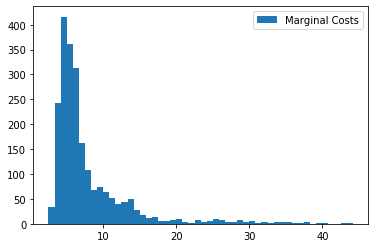

In [11]:
costs = results.compute_costs()
plt.hist(costs, bins=50);
plt.legend(["Marginal Costs"]);

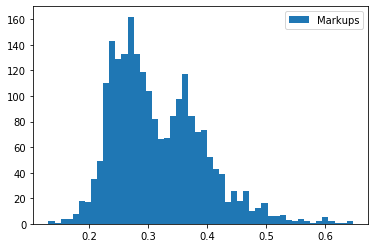

In [12]:
markups = results.compute_markups(costs=costs)
plt.hist(markups, bins=50);
plt.legend(["Markups"]);

In [13]:
profits = results.compute_profits(costs=costs)
cs = results.compute_consumer_surpluses()

# Exercise 2: Merger

Assume all automobile producers in the EU merge. (*Hint: use the column `region`
in the BLP dataset.*)

In [14]:
eu = product_data['region']=='EU'
first_eu_firm_id = product_data['firm_ids'][eu].iloc[0]

In [15]:
product_data['merger_ids'] = product_data['firm_ids']
product_data.loc[eu, 'merger_ids'] = first_eu_firm_id

(a) Plot a histogram of changed profits

In [16]:
changed_prices = results.compute_prices(
    firm_ids=product_data['merger_ids'], 
    costs=costs
)
changed_shares = results.compute_shares(changed_prices)

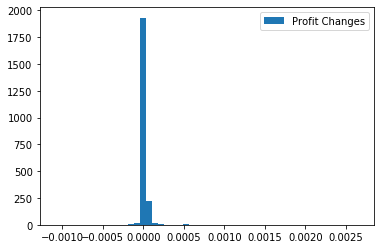

In [17]:
changed_profits = results.compute_profits(changed_prices, changed_shares, costs)
plt.hist(changed_profits - profits, bins=50);
plt.legend(["Profit Changes"]);

(b) Plot a histogram of changed consumer surplus

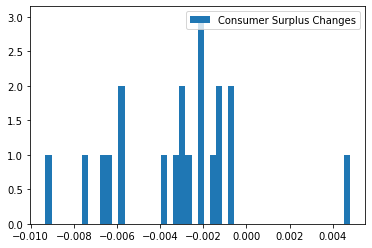

In [18]:
changed_cs = results.compute_consumer_surpluses(changed_prices)
plt.hist(changed_cs - cs, bins=50);
plt.legend(["Consumer Surplus Changes"]);

(c) Plot a histogram of the changed markups after the merger.

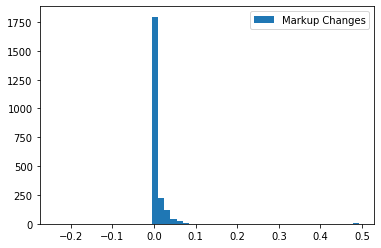

In [19]:
changed_markups = results.compute_markups(changed_prices, costs)
plt.hist(changed_markups - markups, bins=50);
plt.legend(["Markup Changes"]);

(d) Create a scatterplot of pre-merger and post-merger markups for the various products. (*Hint: you can create a scatterplot with the command `plt.plot(x,y,'.')` for arrays `x` and `y`.)

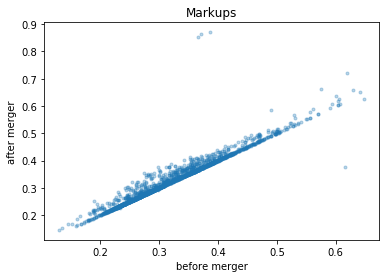

In [20]:
plt.plot(markups, changed_markups, '.', alpha=0.3)
plt.xlabel('before merger')
plt.ylabel('after merger')
plt.title('Markups');